# Data Investigation

Looking data for the project. Data consists of two sets of data, data from a pipe (manhole) upstream whcih is velocity, level, and flow for a specific manhole. The second set has data from downstream CSO outafll structure. 

## Manhole Data Overview

Three files Flow, Level, Velocity. 
* These are values for the input flow, level, and velocity of a large pipe within the system
* This is a 'node' according to their terminology
* Which is a flow meter upstream of a CSO (combined sewer overflow).  This sensor reports level, velocity and flow at a specific manhole from `8/18/2017` – `9/6/2018`.

## Outfall Structure Data Overview

* Radar Rainfall - Float, every 5 minutes
    * This is the depth in inches of rain that has fallen in the area upstream of the outfall structure in the preceding 5 minutes.
* Sewer Level - Float, every 5 minutes
    * This is the elevation of the water inside the trucnk sewer, which is the pipe that collects flows from the upstream area and conveys it to the outfall structure.  When it gets above 546.58 FT, then the sewer is overflowing out the outfall structure to the receiving stream (that’s a bad thing!)



# Loading Data Files

Location of dataset files on local compute to load the related data and information.


In [41]:
import os
mypath = "."

datasets_folder = os.path.join(mypath, "Datasets")
output_folder = os.path.join(mypath, "Datasets-Synchronized")

In [42]:
# List of all data files that can be loaded

data_files = [
    {
        "name": "flow",
        "type": "float",
        "skiprows": 0,
        "filename": "flow.csv"
    },
    {
        "name": "level",
        "type": "float",
        "skiprows": 0,
        "filename": "level.csv"
    },
    {
        "name": "velocity",
        "type": "float",
        "skiprows": 0,
        "filename": "velocity.csv"
    },
    {
        "name": "rainfall",
        "type": "float",
        "skiprows": 1,
        "filename": "rainfall.csv"
    },
    {
        "name": "outfall level",
        "type": "float",
        "skiprows": 1,
        "filename": "outfall_level.csv"
    }
]

# Some useful lookup information
dataset_names = [dataset["name"] for dataset in data_files]
dataset_lookup = {dataset["name"]: dataset for dataset in data_files}


This next secion loads the data into a dictionary of

In [43]:
import pandas as pd
import os

loaded_data = dict()

for data_file in data_files:
    name = data_file["name"]
    data_type = data_file["type"]
    skiprows = data_file["skiprows"]
    filename = data_file["filename"]

    print("Loading file: %s" % (filename))
    print("File stored at path %s" % os.path.join(datasets_folder, filename))

    data_table = pd.read_csv(os.path.join(datasets_folder, filename), skiprows=skiprows)
    # First column has timestamp, second has data
    loaded_data[name] = data_table.iloc[:,[0,1]]
    
    # Skip the rows that have empty/invalid timestamps, seems to be a problem in the dataset as of now
    loaded_data[name].iloc[:,0] = pd.to_datetime(loaded_data[name].iloc[:,0], errors="coerce")
    valid_rows = data_table.iloc[:,0].notna()
    loaded_data[name] = loaded_data[name].loc[valid_rows, :]
    print("Found %i invalid rows" % (data_table.iloc[:,0].shape[0] - valid_rows.sum()))

    # Convert data type of column
    loaded_data[name].iloc[:,1] = pd.to_numeric(loaded_data[name].iloc[:,1], errors="coerce")

    # rename columns
    loaded_data[name].columns = ["timestamp", name]

numpy_datasets = dict()
for attr in dataset_names:
    numpy_datasets[attr] = {
        "timestamp": loaded_data[attr]["timestamp"].to_numpy(),
        attr: loaded_data[attr][attr].to_numpy()
    }


Loading file: flow.csv
File stored at path ./Datasets/flow.csv
Found 0 invalid rows
Loading file: level.csv
File stored at path ./Datasets/level.csv
Found 0 invalid rows
Loading file: velocity.csv
File stored at path ./Datasets/velocity.csv
Found 0 invalid rows
Loading file: rainfall.csv
File stored at path ./Datasets/rainfall.csv
Found 0 invalid rows
Loading file: outfall_level.csv
File stored at path ./Datasets/outfall_level.csv
Found 0 invalid rows


## Stastics on Dataset

This section of code will process some general stastics on the various loaded sections of the dataset. 


In [44]:
import numpy as np
stastics = dict()

print("| " + " | ".join(["name", "count", "min", "max", "std", "mean", "invalid", "start", "end", "average interval", "interval_std"]) + " |")
print("| " + " | ".join(["---"] * 11) + " |")

for name in loaded_data:
    column_data = loaded_data[name]

    filtered = column_data.dropna()

    total_entries = column_data.shape[0]
    data_minimum  = filtered.iloc[:,1].min()
    data_maximum  = filtered.iloc[:,1].max()
    data_stdev = "Not Applicable"
    data_mean  = "Not Applicable"
    data_stdev    = filtered.iloc[:,1].std()
    data_mean     = filtered.iloc[:,1].mean()
    data_invalid  = column_data.iloc[:,1].isna().sum()

    # print(column_data.dtypes)

    date_start = filtered.iloc[:,0].min()
    date_end   = filtered.iloc[:,0].max()

    dates = filtered.iloc[:,0].to_numpy();
    np.sort(dates)

    intervals = (dates[1:] - dates[:(dates.shape[0] - 1)]).astype('timedelta64[s]')
    mean_interval = intervals.mean()
    interval_std = intervals.astype(float).std().astype('timedelta64[s]')

    stastics[name] = {
        "count": total_entries,
        "min": data_minimum,
        "max": data_maximum,
        "std": data_stdev,
        "mean": data_mean,
        "invalid": data_invalid,
        "start": date_start,
        "end": date_end,
        "avg_interval": mean_interval,
        "interval_std": interval_std
    }

    print("| " + " | ".join(
        list(map(str, [
            name,
            total_entries,
            round(data_minimum, 3),
            round(data_maximum, 3),
            round(data_stdev, 3),
            round(data_mean, 3),
            data_invalid,
            date_start,
            date_end,
            mean_interval,
            interval_std
        ]))) + " |")


| name | count | min | max | std | mean | invalid | start | end | average interval | interval_std |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| flow | 110317 | 4.205 | 12.315 | 1.167 | 8.25 | 0 | 2017-08-18 17:30:00 | 2018-09-06 17:40:00 | 300 seconds | 177 seconds |
| level | 110285 | 6.285 | 16.578 | 1.478 | 11.437 | 0 | 2017-08-18 17:30:00 | 2018-09-06 17:40:00 | 300 seconds | 198 seconds |
| velocity | 110285 | 1.933 | 5.032 | 0.446 | 3.477 | 0 | 2017-08-18 17:30:00 | 2018-09-06 17:40:00 | 300 seconds | 198 seconds |
| rainfall | 474608 | 0.053 | 0.157 | 0.015 | 0.105 | 0 | 2017-08-18 00:01:00 | 2018-09-06 00:00:00 | 69 seconds | 88 seconds |
| outfall level | 44906 | 517.846 | 550.286 | 4.95 | 533.997 | 0 | 2017-08-18 00:05:00 | 2018-09-05 23:56:00 | 738 seconds | 6892 seconds |


## Overview of Dataset

Collected stastics on loaded data

| name | count | min | max | std | mean | invalid | start | end | average interval | interval_std |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| flow | 110317 | 4.205 | 12.315 | 1.167 | 8.25 | 0 | 2017-08-18 17:30:00 | 2018-09-06 17:40:00 | 300 seconds | 177 seconds |
| level | 110285 | 6.285 | 16.578 | 1.478 | 11.437 | 0 | 2017-08-18 17:30:00 | 2018-09-06 17:40:00 | 300 seconds | 198 seconds |
| velocity | 110285 | 1.933 | 5.032 | 0.446 | 3.477 | 0 | 2017-08-18 17:30:00 | 2018-09-06 17:40:00 | 300 seconds | 198 seconds |
| rainfall | 474608 | 0.053 | 0.157 | 0.015 | 0.105 | 0 | 2017-08-18 00:01:00 | 2018-09-06 00:00:00 | 69 seconds | 88 seconds |
| outfall level | 44906 | 517.846 | 550.286 | 4.95 | 533.997 | 0 | 2017-08-18 00:05:00 | 2018-09-05 23:56:00 | 738 seconds | 6892 seconds |


## Visualizing Intervals

I am intrigued that all the intervals do not exactly align as well as the fact that various intervals (suc as for the MC-EB-103 dataset) have different gaps for the same average interval. I will plot the various intervals as a density chart for each of the datasets and observe how the look.


Found 2 intervals grater than 1500 seconds for dataset flow
Found 0 intervals less than 0 minutes for dataset flow
Found 2 intervals grater than 1500 seconds for dataset level
Found 0 intervals less than 0 minutes for dataset level
Found 2 intervals grater than 1500 seconds for dataset velocity
Found 0 intervals less than 0 minutes for dataset velocity
Found 6 intervals grater than 1500 seconds for dataset rainfall
Found 0 intervals less than 0 minutes for dataset rainfall
Found 174 intervals grater than 1500 seconds for dataset outfall level
Found 0 intervals less than 0 minutes for dataset outfall level


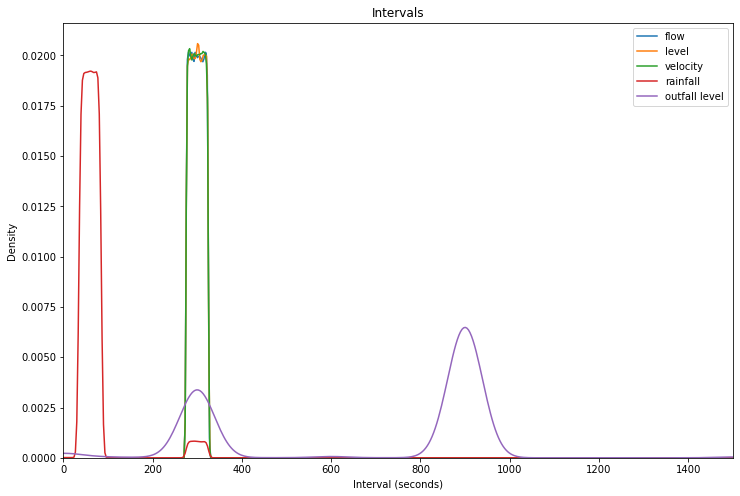

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(12,8))

# limit intervals on plot to less than 25 minutes
max_cutoff = 25 * 60

noise = 50

for name in loaded_data:
    column_data = loaded_data[name]

    filtered = column_data.dropna()

    dates = filtered.iloc[:,0].to_numpy()
    dates.sort()

    intervals = (dates[1:] - dates[:(dates.shape[0] - 1)]).astype('timedelta64[s]').astype(float)

    print("Found %i intervals grater than %s seconds for dataset %s" % ((intervals > max_cutoff).sum(), str(max_cutoff), name))
    print("Found %i intervals less than 0 minutes for dataset %s" % ((intervals < 0).sum(), name))

    intervals[intervals > max_cutoff] = max_cutoff
    intervals[intervals < 0] = 0

    # Adding some jitter to points to avoid errors with no standard deviation
    intervals += np.random.rand(len(intervals)) * noise - noise / 2

    # print(max(intervals))
    # print(min(intervals))

    sns.kdeplot(intervals, ax = ax, label=name, gridsize=500)

ax.legend()
plt.title("Intervals")
ax.set_ylabel("Density") 
ax.set_xlabel("Interval (seconds)")
ax.set_xlim(left=0, right=max_cutoff)

plt.show()


# Overflow State

The system is considered in overflow when the sewer level is greater than 546.58FT.


In [6]:
overflow_level = 546.58

overflow_instances = (loaded_data["outfall level"]["outfall level"] >= 546.58).astype("int")

print(sum(overflow_instances))

359


In [7]:
# Time in overflow state
timestamps = loaded_data["outfall level"]["timestamp"]

totalDelta = np.timedelta64(0, "m");

elems = overflow_instances.shape[0]
for idx in range(1, elems):
    if overflow_instances[idx] == 1 or overflow_instances[idx - 1] == 1:
        totalDelta += timestamps[idx] - timestamps[idx - 1]

print("Total time in overflow: %s" % str(np.array(totalDelta).astype("timedelta64[m]")))


Total time in overflow: 7481 minutes


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.distplot(loaded_data["outfall level"]["outfall level"])
plt.axvline(546.58, color="black")


## Overflow Instances


In [45]:
overflow_level = 546.58

overflow_timestamps = loaded_data["outfall level"]["timestamp"]
overflow_instances = (loaded_data["outfall level"]["outfall level"] >= 546.58).astype("int")

print(sum(overflow_instances))

totalDelta = np.timedelta64(0, "m");

elems = overflow_instances.shape[0]

start = None

for idx in range(1, elems):
    if overflow_instances[idx] == 1:
        totalDelta += overflow_timestamps[idx] - overflow_timestamps[idx - 1]
        if overflow_instances[idx - 1] == 0 or idx == 1:
            start = overflow_timestamps[idx - 1]
    else:
        if overflow_instances[idx - 1] == 1:
            end = overflow_timestamps[idx]
            print("Overflow from %s, to %s for %s" % (str(start), str(end), str(np.array(end - start).astype("timedelta64[m]"))))

print("Total time in overflow: %s" % str(np.array(totalDelta).astype("timedelta64[m]")))


355
Overflow from 2017-09-01 01:45:00, to 2017-09-01 04:30:00 for 165 minutes
Overflow from 2017-09-06 20:35:00, to 2017-09-07 00:05:00 for 210 minutes
Overflow from 2017-09-11 01:43:00, to 2017-09-11 04:13:00 for 150 minutes
Overflow from 2017-09-30 11:26:00, to 2017-09-30 14:56:00 for 210 minutes
Overflow from 2017-10-04 12:55:00, to 2017-10-04 14:25:00 for 90 minutes
Overflow from 2017-11-11 23:41:00, to 2017-11-12 03:26:00 for 225 minutes
Overflow from 2017-11-16 09:51:00, to 2017-11-16 10:51:00 for 60 minutes
Overflow from 2017-11-22 18:16:00, to 2017-11-22 22:01:00 for 225 minutes
Overflow from 2017-11-28 02:16:00, to 2017-11-28 03:01:00 for 45 minutes
Overflow from 2017-12-04 06:57:00, to 2017-12-04 10:42:00 for 225 minutes
Overflow from 2017-12-11 12:32:00, to 2017-12-11 16:47:00 for 255 minutes
Overflow from 2017-12-27 23:32:00, to 2017-12-28 01:32:00 for 120 minutes
Overflow from 2018-01-02 23:43:00, to 2018-01-03 04:13:00 for 270 minutes
Overflow from 2018-01-24 11:18:00, to

# Viewing the Dataset

I'm not really sure what's in this dataset, here is some code to view each dataset with aligned time axis values (hopefully).

In [46]:
# Function to find closest index of a date in a list of dates
def find_closest_index(date, element_list, low=None, high=None):
    if low == None and high == None:
        low = 0
        high = len(element_list) - 1
    
    if low + 1 >= high:
        return low

    mid = (low + high) // 2

    if element_list[mid] > date:
        return find_closest_index(date, element_list, low, mid - 1)
    else:
        return find_closest_index(date, element_list, mid, high)

def get_dataset_subset(timestamps, values, start_date, end_date):
    start_index = max(0, find_closest_index(start_date, timestamps))
    end_index = min(len(values), find_closest_index(end_date, timestamps))

    return timestamps[start_index:end_index], values[start_index:end_index]


In [47]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def plot_datasets(start_date, end_date):
    # Create a figure to display the plots
    # * first subplot is for manhole data
    # * second subplot for the sewer level, stream boundary, and interceptor boundary
    #    values as they all seem to fall within a similar-ish range
    # * third subplot for the rainfall data as it seems to be on it's own scale
    # * fourth subplot for the status (just going to plot using a scatter plot)
    fig, (ax_manhole, ax_cso_pipe, ax_cso_rainfall) = plt.subplots(3,1,sharex=True,figsize=(12,6))

    # Groups of data for various plots
    manhole_attr = ["flow", "level", "velocity"]
    cso_pipe_attr = ["outfall level"]

    # Start off with plotting the MC-EB-103 data
    for attr in manhole_attr:
        subset_x, subset_y = get_dataset_subset(numpy_datasets[attr]["timestamp"], numpy_datasets[attr][attr], start_date, end_date)
        sns.lineplot(ax=ax_manhole, x=subset_x, y=subset_y)

    # Then plot the cso pipe data
    for attr in cso_pipe_attr:
        subset_x, subset_y = get_dataset_subset(numpy_datasets[attr]["timestamp"], numpy_datasets[attr][attr], start_date, end_date)
        sns.lineplot(ax=ax_cso_pipe, x=subset_x, y=subset_y)

    # Next plot the rainfall data
    subset_x, subset_y = get_dataset_subset(numpy_datasets["rainfall"]["timestamp"], numpy_datasets["rainfall"]["rainfall"], start_date, end_date)
    sns.lineplot(ax=ax_cso_rainfall, x=subset_x, y = subset_y)

    # Label the plots
    ax_manhole.legend(labels = manhole_attr)
    ax_cso_pipe.legend(labels = cso_pipe_attr)
    ax_cso_rainfall.legend(labels = ["Radar Rainfall"])


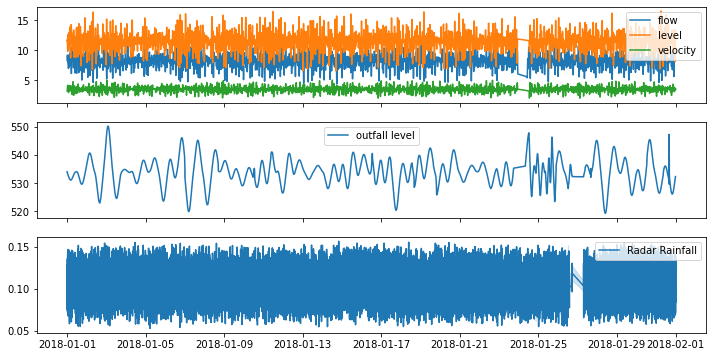

In [48]:
start_date = np.datetime64("2018-01")
end_date   = np.datetime64("2018-02")

plot_datasets(start_date, end_date)

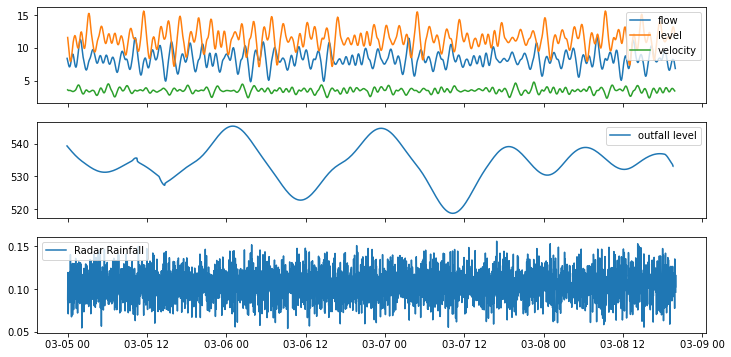

In [49]:
start_date = np.datetime64("2018-03-05 00:00:00")
end_date   = np.datetime64("2018-03-08 20:00:00")

plot_datasets(start_date, end_date)

# Synchronizing the Dataset

So, having that big dataset is nice an all, but without the dataset being synchronized along the time axis, it's difficult to do anything such as data analysis or seting up models for the data. In order to synchroniz this dataset, I will write two approaches:
1. Linear Interpolation
2. Select Nearest (round forward or backward)

These two methods are essentially the same but with different configuration values.

We will create a normalized set of time intervals, say spaced every 5 minutes.
From our dataset we will select the closest data sample from each data point. 
Chances are this time will not fall on exactly where data points are found. We can select from the previous and current one as a function of how close we are to the timestamps (linear interpolation) or just use a fixed weight of closest.

In [50]:
import numpy as np

def generate_timestamps(start, end, interval):
    return np.arange(start, end, interval)

def interpolate_value(points, timestamps, values, rule=None, debug_log=False):
    """Interpolates between two different values for a set of timestamps with a given rule,
    
    points - Timestamp to interpolate value for (in sorted order)
    timestamps - All timestamps for collected dataset
    values - Values at each recorded timestamp
    rule - Rule for interpolationg value, can either be 'proportional', 'start', 'end', 'closest'
        proportional (or none) means blend between the two values
        start means to select the one before the point in the list
        end means to select the one after the point in the list
    """
    total_samples = len(timestamps)
    # timestamps and values must be same length
    assert len(timestamps) == len(values)

    blend = (0.5, 0.5)
    if rule == "end":
        blend = (1, 0)
    elif rule == "start":
        blend = (0, 1)

    normalized = np.zeros(points.shape)

    sample_idx = 0
    # Go through each point to interpolate samples
    for point_idx in range(len(points)):
        # Find the closest (before current point) sample
        current_point = points[point_idx]
        # Closest sample will always be after (or same as) current sample
        while sample_idx < len(timestamps) - 2 and timestamps[sample_idx + 1] < current_point:
            # Go to next sample until a ending sample is found
            sample_idx += 1
        
        #get the points before and after the current index
        time_left = timestamps[sample_idx]
        right_idx = sample_idx + 1
        if right_idx >= len(timestamps):
            right_idx = len(timestamps) - 1
        time_right = timestamps[right_idx]

        if sample_idx == right_idx:
            # If at the end of the list
            normalized[point_idx] = values[sample_idx]
        elif time_left == current_point or time_left >= current_point:
            # If matching (or before) left or right index
            normalized[point_idx] = values[sample_idx]
        elif time_right == current_point:
            normalized[point_idx] = values[right_idx]
        else:
            # Interpolate point between left and right idx
            dist_left = current_point - time_left
            dist_right = time_right - current_point

            dist_left *= blend[0]
            dist_right *= blend[1]

            total_dist = dist_left + dist_right

            normalized_dist_left = dist_left / total_dist
            normalized_dist_right = dist_right / total_dist

            # edge case for duplicate timestamps
            if total_dist == 0:
                normalized[point_idx] = values[sample_idx]

            # Interpolate between the two values
            normalized[point_idx] = values[sample_idx] * (1 - normalized_dist_left) + \
                values[right_idx] * (1 - normalized_dist_right)

        if debug_log:
            print("interpolated: {%s, %0.3f}, left: {%s, %0.3f}, right: {%s, %0.3f}" % 
                (str(current_point), normalized[point_idx],
                str(time_left), values[sample_idx],
                str(time_right), values[right_idx]))

    return normalized


In [51]:
# Test and show correctness of interpolation of timestamp values

# Start and end time 2 hours apart on same day
start_time = np.datetime64("2018-01-15 16:45:20")
end_time   = np.datetime64("2018-01-15 17:15:00")
# Time delta of 5 minutes
interval   = np.timedelta64(5, "m")
# Make timestamps for this sample
points = generate_timestamps(start_time, end_time, interval)

# Get some sample data and its timestamps
flow_timestamps = numpy_datasets['flow']['timestamp']
flow_values = numpy_datasets['flow']['flow']

# Get the time normalized dataset
flow_normalized = interpolate_value(points, flow_timestamps, flow_values)


<ipython-input-50-f4b44f67c524>:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if total_dist == 0:


In [52]:
def get_normalized_df(start_time, end_time, interval):
    # Make timestamps for this sample
    points = generate_timestamps(start_time, end_time, interval)

    # Get the time normalized dataset
    normalized_dict = {'timestamp': points}

    for name in dataset_names:
        dataset_info = dataset_lookup[name]
        data_type = dataset_info["type"]
        dataset = loaded_data[name]

        values = dataset[name]
        valid_indices = np.logical_not(np.isnan(values))
        # print(valid_indices)
        values = np.array(dataset[name][valid_indices])
        timestamps = np.array(dataset["timestamp"][valid_indices])

        rule = "start"
        if data_type == "float":
            rule = None

        normalized = interpolate_value(points, timestamps, values, rule=rule).astype(data_type)

        normalized_dict[name] = normalized

    normalized_data_frame = pd.DataFrame(normalized_dict)
    normalized_data_frame.set_index('timestamp')

    return normalized_data_frame


In [53]:
# Start and end time 2 hours apart on same day
start_time = np.datetime64("2018-04-15 16:45:20")
end_time   = np.datetime64("2018-04-15 18:00:00")
# Time delta of 5 minutes
interval   = np.timedelta64(30, "s")

get_normalized_df(start_time, end_time, interval)

<ipython-input-50-f4b44f67c524>:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if total_dist == 0:


,timestamp,flow,level,velocity,rainfall,outfall level
0,2018-04-15 16:45:20,8.291704,11.206539,3.493073,0.103987,538.536858
1,2018-04-15 16:45:50,8.261845,11.226202,3.498628,0.102077,538.555686
2,2018-04-15 16:46:20,8.231986,11.245865,3.504183,0.105420,538.574514
3,2018-04-15 16:46:50,8.202127,11.265528,3.509738,0.111390,538.593341
4,2018-04-15 16:47:20,8.172268,11.285191,3.515293,0.113747,538.612169
...,...,...,...,...,...,...
145,2018-04-15 17:57:50,10.459875,10.219937,3.479698,0.112132,541.073012
146,2018-04-15 17:58:20,10.520820,10.149620,3.483543,0.114167,541.087832
147,2018-04-15 17:58:50,10.581765,10.079303,3.487388,0.111972,541.102653
148,2018-04-15 17:59:20,10.642710,10.008986,3.491233,0.109153,541.117473


## Visualize Normalized Dataset

Now we are going to start off by creating a normalized dataset with one sample every 5 minutes. Then from this normalized dataset we are going to plot out the datasets.

In [54]:
# Start and end time 2 hours apart on same day
start_time = np.datetime64("2017-08-18 17:30:00")
end_time   = np.datetime64("2018-09-06 17:40:00")
# Time delta of 5 minutes
interval   = np.timedelta64(5, "m")

normalized_dataset = get_normalized_df(start_time, end_time, interval)

<ipython-input-50-f4b44f67c524>:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if total_dist == 0:


In [55]:
normalized_dataset

,timestamp,flow,level,velocity,rainfall,outfall level
0,2017-08-18 17:30:00,6.11732,8.73560,3.69814,0.12087,532.803797
1,2017-08-18 17:35:00,6.23406,8.88357,3.69513,0.10569,532.898260
2,2017-08-18 17:40:00,6.59119,9.33617,3.63417,0.09501,532.982497
3,2017-08-18 17:45:00,7.09177,9.97049,3.53526,0.09753,533.066733
4,2017-08-18 17:50:00,7.60113,10.61579,3.42651,0.10100,533.150970
...,...,...,...,...,...,...
110589,2018-09-06 17:15:00,9.24220,12.69517,3.55513,1.26963,563.716558
110590,2018-09-06 17:20:00,8.55400,11.82342,3.49229,1.27523,563.849718
110591,2018-09-06 17:25:00,7.81356,10.88527,3.45861,1.28083,563.982878
110592,2018-09-06 17:30:00,7.08293,9.95949,3.46105,1.28643,564.116038


In [56]:
def plot_norm_datasets(start_date, end_date):
    # Create a figure to display the plots
    # * first subplot is for MC-EB-103 data
    # * second subplot for the sewer level, stream boundary, and interceptor boundary
    #    values as they all seem to fall within a similar-ish range
    # * third subplot for the rainfall data as it seems to be on it's own scale
    # * fourth subplot for the status (just going to plot using a scatter plot)
    fig, (ax_manhole, ax_cso_pipe, ax_cso_rainfall) = plt.subplots(3,1,sharex=True,figsize=(12,6))

    timestamps = normalized_dataset["timestamp"]
    rows_selected = np.logical_and(start_date <= timestamps, timestamps <= end_date)

    selected_timestamps = normalized_dataset.loc[rows_selected]["timestamp"]
    # Groups of data for various plots
    manhole_attr = ["flow", "level", "velocity"]
    cso_pipe_attr = ["outfall level"]

    # Start off with plotting the MC-EB-103 data
    for attr in manhole_attr:
        sns.lineplot(selected_timestamps, normalized_dataset.loc[rows_selected,attr], ax=ax_manhole)

    # Then plot the cso pipe data
    for attr in cso_pipe_attr:
        sns.lineplot(selected_timestamps, normalized_dataset.loc[rows_selected,attr], ax=ax_cso_pipe)

    # Next plot the rainfall data
    sns.lineplot(ax=ax_cso_rainfall, x=selected_timestamps, y=normalized_dataset.loc[rows_selected,"rainfall"])

    # Label the plots
    ax_manhole.legend(labels = manhole_attr)
    ax_cso_pipe.legend(labels = cso_pipe_attr)
    ax_cso_rainfall.legend(labels = ["rainfall"])

In [ ]:
start_date = np.datetime64("2017-01")
end_date   = np.datetime64("2019-01")

plot_norm_datasets(start_date, end_date)

In [ ]:
start_date = np.datetime64("2018-01")
end_date   = np.datetime64("2018-02")

plot_norm_datasets(start_date, end_date)

In [ ]:
start_date = np.datetime64("2018-03-05 00:00:00")
end_date   = np.datetime64("2018-03-08 20:00:00")

plot_norm_datasets(start_date, end_date)

## Saving Synchronized Dataset

This next section focuses on saving the generated normalized dataset.


In [60]:
# Start and end of whole dataset
start_time = np.datetime64("2017-08-18 17:30:00")
end_time   = np.datetime64("2018-09-06 17:40:00")
# ensure output directory exsits
os.makedirs(output_folder, exist_ok=True)

sync_datasets = dict()

# Time delta of 60 seconds
interval   = np.timedelta64(60, "s")
sync_datasets[60] = get_normalized_df(start_time, end_time, interval)

# Time delta of 5 minutes
interval   = np.timedelta64(5, "m")
sync_datasets[5] = get_normalized_df(start_time, end_time, interval)

# Time delta of 15 minutes
interval   = np.timedelta64(15, "m")
sync_datasets[15] = get_normalized_df(start_time, end_time, interval)


<ipython-input-50-f4b44f67c524>:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if total_dist == 0:


In [61]:
delta = 60
dataset_name = "%i-sec-norm.csv" % (delta)
print("Saving datasets " + dataset_name)
sync_datasets[delta].round(5).to_csv(os.path.join(output_folder, dataset_name), index=False)
dataset_name = "%i-sec-norm.hdf" % (delta)
print("Saving datasets " + dataset_name)
sync_datasets[delta].round(5).to_hdf(os.path.join(output_folder, dataset_name), key='delta_1', mode='w')

Saving datasets 60-sec-norm.csv
Saving datasets 60-sec-norm.hdf


In [62]:
!conda install -c anaconda pytables -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



## Overflow in Synchronized Dataset

Analysis of overflow events in synchronized dataset



In [63]:
# Get the dataset with the 5 minute interval
sync_data_5_min = sync_datasets[5]

overflow_level = 546.58

overflow_instances = (sync_data_5_min["outfall level"] >= 546.58).astype("int")

print(sum(overflow_instances))

# Time in overflow state
timestamps = sync_data_5_min["timestamp"]

totalDelta = np.timedelta64(0, "m");

elems = overflow_instances.shape[0]
for idx in range(1, elems):
    if overflow_instances[idx] == 1:
        totalDelta += timestamps[idx] - timestamps[idx - 1]

print("Total time in overflow: %s" % str(np.array(totalDelta).astype("timedelta64[m]")))


2304
Total time in overflow: 11520 minutes


In [64]:
overflow_level = 546.58

overflow_timestamps = sync_data_5_min["timestamp"]
overflow_instances = (sync_data_5_min["outfall level"] >= 546.58).astype("int")

print(sum(overflow_instances))

totalDelta = np.timedelta64(0, "m");

elems = overflow_instances.shape[0]

start = None

for idx in range(1, elems):
    if overflow_instances[idx] == 1:
        totalDelta += overflow_timestamps[idx] - overflow_timestamps[idx - 1]
        if overflow_instances[idx - 1] == 0 or idx == 1:
            start = overflow_timestamps[idx - 1]
    else:
        if overflow_instances[idx - 1] == 1:
            end = overflow_timestamps[idx]
            print("Overflow from %s, to %s for %s" % (str(start), str(end), str(np.array(end - start).astype("timedelta64[m]"))))

print("Total time in overflow: %s" % str(np.array(totalDelta).astype("timedelta64[m]")))


2304
Overflow from 2017-09-01 01:50:00, to 2017-09-01 04:25:00 for 155 minutes
Overflow from 2017-09-06 20:40:00, to 2017-09-07 00:05:00 for 205 minutes
Overflow from 2017-09-11 01:50:00, to 2017-09-11 04:05:00 for 135 minutes
Overflow from 2017-09-30 11:30:00, to 2017-09-30 15:00:00 for 210 minutes
Overflow from 2017-10-04 12:55:00, to 2017-10-04 14:20:00 for 85 minutes
Overflow from 2017-11-11 23:50:00, to 2017-11-12 03:25:00 for 215 minutes
Overflow from 2017-11-16 09:55:00, to 2017-11-16 10:40:00 for 45 minutes
Overflow from 2017-11-22 18:25:00, to 2017-11-22 21:50:00 for 205 minutes
Overflow from 2017-11-28 02:15:00, to 2017-11-28 03:00:00 for 45 minutes
Overflow from 2017-12-04 07:05:00, to 2017-12-04 10:30:00 for 205 minutes
Overflow from 2017-12-11 12:40:00, to 2017-12-11 16:45:00 for 245 minutes
Overflow from 2017-12-27 23:35:00, to 2017-12-28 01:20:00 for 105 minutes
Overflow from 2018-01-02 23:55:00, to 2018-01-03 04:00:00 for 245 minutes
Overflow from 2018-01-24 11:30:00, t

## Distribution of Sewer Level

Visualize the total composition of the sewer level values

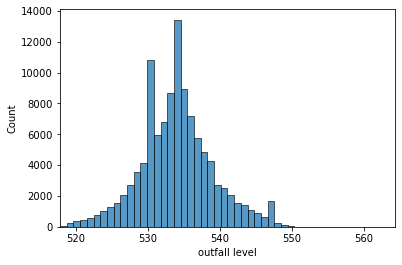

In [65]:
levels = sync_data_5_min["outfall level"]

min_level, max_level = np.min(levels), np.max(levels)

fig, ax = plt.subplots()
sns.histplot(levels, ax=ax, bins=50)
ax.set(xlim=(min_level, max_level))
plt.show()

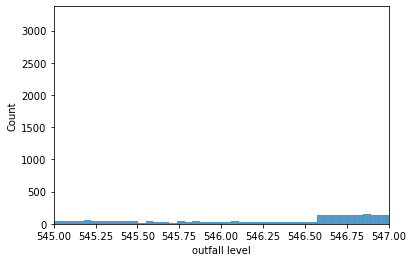

In [66]:
levels = sync_data_5_min["outfall level"]

min_level, max_level = 545, 547

fig, ax = plt.subplots()
sns.histplot(levels, ax=ax, bins=1000)
ax.set(xlim=(min_level, max_level))
plt.show()

In [67]:
cutoffs = np.linspace(0, 1, 21)
quantiles = np.quantile(levels, q=cutoffs)

print("Overflow cutoff at %3.2f" % 546.58)
print("Dataset Quantiles")
for cutoff, quantile in zip(cutoffs, quantiles):
    print("%0.2f : %3.2f" % (cutoff, quantile))

Overflow cutoff at 546.58
Dataset Quantiles
0.00 : 517.85
0.05 : 525.76
0.10 : 528.05
0.15 : 529.46
0.20 : 530.06
0.25 : 530.49
0.30 : 531.42
0.35 : 532.22
0.40 : 532.94
0.45 : 533.52
0.50 : 533.93
0.55 : 534.26
0.60 : 534.72
0.65 : 535.31
0.70 : 535.97
0.75 : 536.77
0.80 : 537.72
0.85 : 538.84
0.90 : 540.57
0.95 : 543.34
1.00 : 564.25


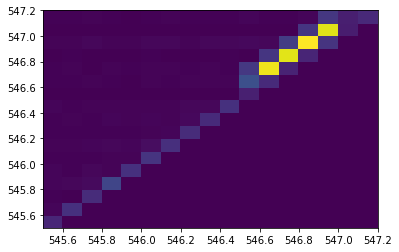

In [68]:
from scipy.ndimage.filters import maximum_filter1d

# sample length = 5 minutes
sample_length = 5
# window size of 24 hours = 24 * 60 minutes per hour
window_size = 24 * 60
# number of samples per window
window_samples = window_size // sample_length
data = np.array(levels)

# window_samples = 3
# data = np.array([0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0, 5, 4, 3])
offset = - int(np.floor(window_samples / 2))

rolling_max = maximum_filter1d(data, mode="constant", cval=0.0, size=window_samples, origin = offset)

data_length = len(data)

subset_data = data[:data_length-window_samples]
subset_roll = rolling_max[:data_length-window_samples]
# for elem, max_elem in zip(data, rolling_max):
#     print(elem, max_elem)

data_combined = np.column_stack((subset_data, subset_roll))
result = plt.hist2d(subset_data,subset_roll, bins=[np.arange(545.5, 547.21, 0.1),np.arange(545.5, 547.21, 0.1)])


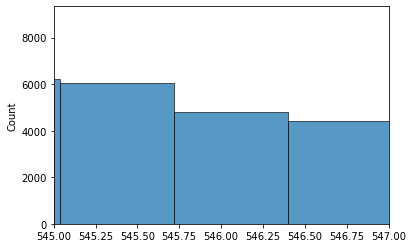

In [69]:
fig, ax = plt.subplots()
sns.histplot(subset_roll, ax=ax, bins=50)
ax.set(xlim=(min_level, max_level))
plt.show()

# Synchronized Dataset Correlation

Looking into correlation coefficient for the synchronized dataset just to see if there are any strong trends in the dataset.


In [70]:
# Get the dataset with the 5 minute interval
sync_data_5_min = sync_datasets[5]

# Filter between valid start and end date
start_date = np.datetime64("2017-10-11 11:51:00")
end_date   = np.datetime64("2018-09-05 23:58:00")

# Get the dataset with the 15 minute interval
sync_data_15_min = sync_datasets[15]

# Filter between valid start and end date
start, end = np.datetime64("2017-12-31 23:59:00"), np.datetime64("2018-09-05 23:58:00")

# Select datatset within filter
timestamps = sync_data_15_min["timestamp"].to_numpy()
samples_in_range = np.logical_and(timestamps >= start, timestamps <= end)
sync_data_15_min_filtered = sync_data_15_min.loc[samples_in_range, :]

selected_columns = ["flow", "velocity", "level", "rainfall","outfall level"]

correlation_matrix = sync_data_15_min_filtered[selected_columns].corr()

<AxesSubplot:>

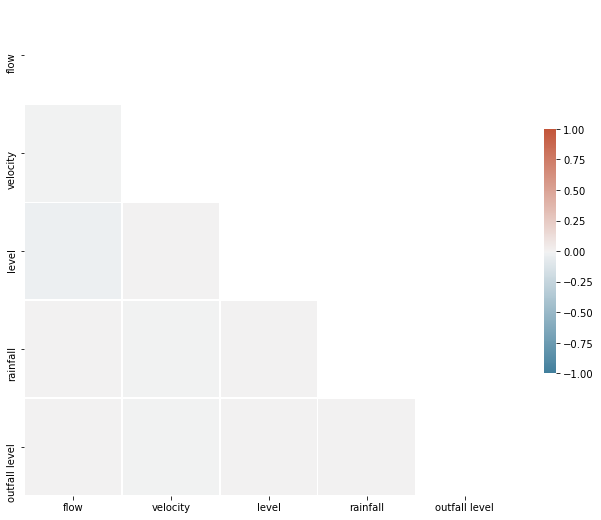

In [71]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
